In [1]:
import os
import glob
import pandas as pd
import re # For more robust number extraction
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting
import numpy as np # For potential numerical operations, e.g. np.nan

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import os
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from datetime import datetime, timedelta



In [2]:
def combine_log_files(data_folder_path: str) -> pd.DataFrame:
    """
    Reads all LOG_*.TXT files from the specified folder, sorts them numerically,
    and combines them into a single Pandas DataFrame.

    Args:
        data_folder_path (str): The path to the folder containing the .txt log files.

    Returns:
        pd.DataFrame: A DataFrame containing all combined data, or an empty
                      DataFrame if no suitable files are found or an error occurs.
    """
    if not os.path.isdir(data_folder_path):
        print(f"Error: Folder '{data_folder_path}' not found.")
        return pd.DataFrame()

    all_files_in_folder = glob.glob(os.path.join(data_folder_path, "*"))
    
    txt_files = []
    for f_path in all_files_in_folder:
        filename = os.path.basename(f_path)
        if filename.upper().startswith("LOG_") and filename.upper().endswith(".TXT"):
            txt_files.append(f_path)

    if not txt_files:
        print(f"No LOG_*.TXT files found in '{data_folder_path}'.")
        return pd.DataFrame()

    def sort_key(filepath):
        filename = os.path.basename(filepath)
        match = re.search(r'LOG_(\d+)\.TXT', filename, re.IGNORECASE)
        if match:
            return int(match.group(1))
        return float('inf') 

    sorted_files = sorted(txt_files, key=sort_key)
    
    print("Files to be processed in order:")
    for f in sorted_files:
        print(f"  - {os.path.basename(f)}")

    all_dataframes = []
    for file_path in sorted_files:
        try:
            df = pd.read_csv(file_path)
            all_dataframes.append(df)
            print(f"Successfully read and processed: {os.path.basename(file_path)}")
        except pd.errors.EmptyDataError:
            print(f"Warning: File {os.path.basename(file_path)} is empty and will be skipped.")
        except Exception as e:
            print(f"Error reading file {os.path.basename(file_path)}: {e}")

    if not all_dataframes:
        print("No data could be read from the files.")
        return pd.DataFrame()

    combined_df = pd.concat(all_dataframes, ignore_index=True)
    return combined_df


In [3]:
input_folder = "Data_In" 
output_folder = "Data_Out" # Define the output folder


combined_data = combine_log_files(input_folder)
df = combined_data
if not combined_data.empty:
    print("\n--- Combined DataFrame ---")
    print("Shape:", combined_data.shape)
    print("\nHead:")
    print(combined_data.head())

Files to be processed in order:
  - LOG_19.TXT
Successfully read and processed: LOG_19.TXT

--- Combined DataFrame ---
Shape: (17806, 23)

Head:
   Log_Index  CPU_TempC  BMP_TempC  BMP_PressPa  CO2_ppm  SCD30_TempC  \
0          0      25.00      21.16     99696.42        0        20.97   
1          1      24.33      21.16     99696.42        0        20.97   
2          2      25.00      21.16     99696.41      485        20.97   
3          3      25.00      21.16     99696.39      485        20.97   
4          4      25.00      21.16     99696.38      592        20.99   

   SCD30_Hum_%  SHT_TempC  SHT_Hum_%  GPS_Lat  ...  GPS_Month  GPS_Day  \
0        36.61      21.29      27.32      0.0  ...          0        0   
1        36.61      21.38      27.30      0.0  ...          0        0   
2        36.65      21.37      27.24      0.0  ...          0        0   
3        36.65      21.38      27.16      0.0  ...          0        0   
4        36.66      21.41      27.06      0.0 

In [4]:
os.makedirs(output_folder, exist_ok=True)
print(f"\nSaving plots to folder: {output_folder}")

# Apply a publication-ready style
style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# --- Data Preparation for Plot 1 Time Axis ---
df_plotting = df.copy()

gps_datetime_cols = ['GPS_Year', 'GPS_Month', 'GPS_Day', 'GPS_Hour', 'GPS_Min', 'GPS_Sec']
for col in gps_datetime_cols:
    df_plotting[col] = pd.to_numeric(df_plotting[col], errors='coerce')

df_plotting['GPS_DateTime_Valid'] = pd.NaT

valid_gps_mask = (
    (df_plotting['GPS_Fix'] == 1) &
    (df_plotting['GPS_Year'] > 0) &
    (df_plotting['GPS_Month'] >= 1) & (df_plotting['GPS_Month'] <= 12) &
    (df_plotting['GPS_Day'] >= 1) & (df_plotting['GPS_Day'] <= 31) &
    (df_plotting['GPS_Hour'] >= 0) & (df_plotting['GPS_Hour'] <= 23) &
    (df_plotting['GPS_Min'] >= 0) & (df_plotting['GPS_Min'] <= 59) &
    (df_plotting['GPS_Sec'] >= 0) & (df_plotting['GPS_Sec'] <= 59)
)

datetime_constructor_df = pd.DataFrame({
    'year': df_plotting.loc[valid_gps_mask, 'GPS_Year'],
    'month': df_plotting.loc[valid_gps_mask, 'GPS_Month'],
    'day': df_plotting.loc[valid_gps_mask, 'GPS_Day'],
    'hour': df_plotting.loc[valid_gps_mask, 'GPS_Hour'],
    'minute': df_plotting.loc[valid_gps_mask, 'GPS_Min'],
    'second': df_plotting.loc[valid_gps_mask, 'GPS_Sec']
})

if not datetime_constructor_df.empty:
    # Ensure all columns are numeric before passing to to_datetime
    for col in datetime_constructor_df.columns:
        datetime_constructor_df[col] = pd.to_numeric(datetime_constructor_df[col], errors='coerce')
    
    # Drop rows with any NaNs that might have been introduced by coerce, before to_datetime
    datetime_constructor_df.dropna(inplace=True)

    if not datetime_constructor_df.empty:
         # Assign back to the original DataFrame's filtered view (df_plotting.loc[valid_gps_mask])
         # The index of datetime_constructor_df matches the True values in valid_gps_mask
        df_plotting.loc[datetime_constructor_df.index, 'GPS_DateTime_Valid'] = pd.to_datetime(datetime_constructor_df, errors='coerce')


df_plotting['Plot_Time'] = pd.NaT

if not df_plotting['GPS_DateTime_Valid'].isnull().all():
    first_valid_dt_idx = df_plotting['GPS_DateTime_Valid'].first_valid_index()
    if first_valid_dt_idx is not None:
        df_plotting.loc[first_valid_dt_idx, 'Plot_Time'] = df_plotting.loc[first_valid_dt_idx, 'GPS_DateTime_Valid']
        # Backfill time for rows before the first valid GPS time
        for i in range(first_valid_dt_idx - 1, -1, -1):
            # Check if previous Plot_Time is already set (e.g. by another valid GPS point)
            # This check is mostly for robustness, standard loop should be fine
            if pd.isna(df_plotting.loc[i+1, 'Plot_Time']): # Should not happen in this loop
                break 
            df_plotting.loc[i, 'Plot_Time'] = df_plotting.loc[i + 1, 'Plot_Time'] - pd.Timedelta(seconds=1)
        
        # Fill subsequent NaNs or use GPS time
        for i in range(first_valid_dt_idx + 1, len(df_plotting)):
            if pd.notna(df_plotting.loc[i, 'GPS_DateTime_Valid']):
                df_plotting.loc[i, 'Plot_Time'] = df_plotting.loc[i, 'GPS_DateTime_Valid']
            else:
                if pd.isna(df_plotting.loc[i-1, 'Plot_Time']): # If previous is also NaN, cannot increment
                     # This could happen if there's a large gap of non-GPS data after first_valid_dt_idx
                     # and before another valid GPS_DateTime_Valid.
                     # For now, let it be NaT, to be caught by the manual input if all Plot_Time is NaT.
                     # Or, one could decide to keep incrementing.
                     # If this creates an issue, this logic might need refinement for sparse GPS data.
                     pass # Keep as NaT
                else:
                     df_plotting.loc[i, 'Plot_Time'] = df_plotting.loc[i-1, 'Plot_Time'] + pd.Timedelta(seconds=1)
    # else: # first_valid_dt_idx is None, but not all GPS_DateTime_Valid are null. This is unlikely.
        # If this happens, Plot_Time will remain all NaT, and the manual input logic will trigger.
    #    pass

# MODIFIED SECTION FOR MANUAL TIME INPUT
if df_plotting['Plot_Time'].isnull().all():
    print("Warning: No valid GPS time found in any row to anchor the timeline, or issues populating Plot_Time.")
    print("The time axis for plots will be based on a manually entered start time.")
    while True:
        manual_start_time_str = input("Please enter the start datetime of the experiment (e.g., 'YYYY-MM-DD HH:MM:SS'): ")
        try:
            start_time = pd.to_datetime(manual_start_time_str)
            print(f"Using manually entered start time: {start_time} for the time axis.")
            df_plotting['Plot_Time'] = [start_time + pd.Timedelta(seconds=i) for i in range(len(df_plotting))]
            break 
        except ValueError:
            print("Invalid datetime format. Please use a format like 'YYYY-MM-DD HH:MM:SS' (e.g., '2023-01-01 14:30:00'). Try again.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}. Please check your input and try again.")

df_plotting['BMP_PressAtm'] = df_plotting['BMP_PressPa'] / 101325.0


Saving plots to folder: Data_Out
The time axis for plots will be based on a manually entered start time.


Please enter the start datetime of the experiment (e.g., 'YYYY-MM-DD HH:MM:SS'):  2025-05-09 12:00:00


Using manually entered start time: 2025-05-09 12:00:00 for the time axis.


Generating Plot 1: Time Series Data...
Saved: Data_Out\plot1_time_series.png


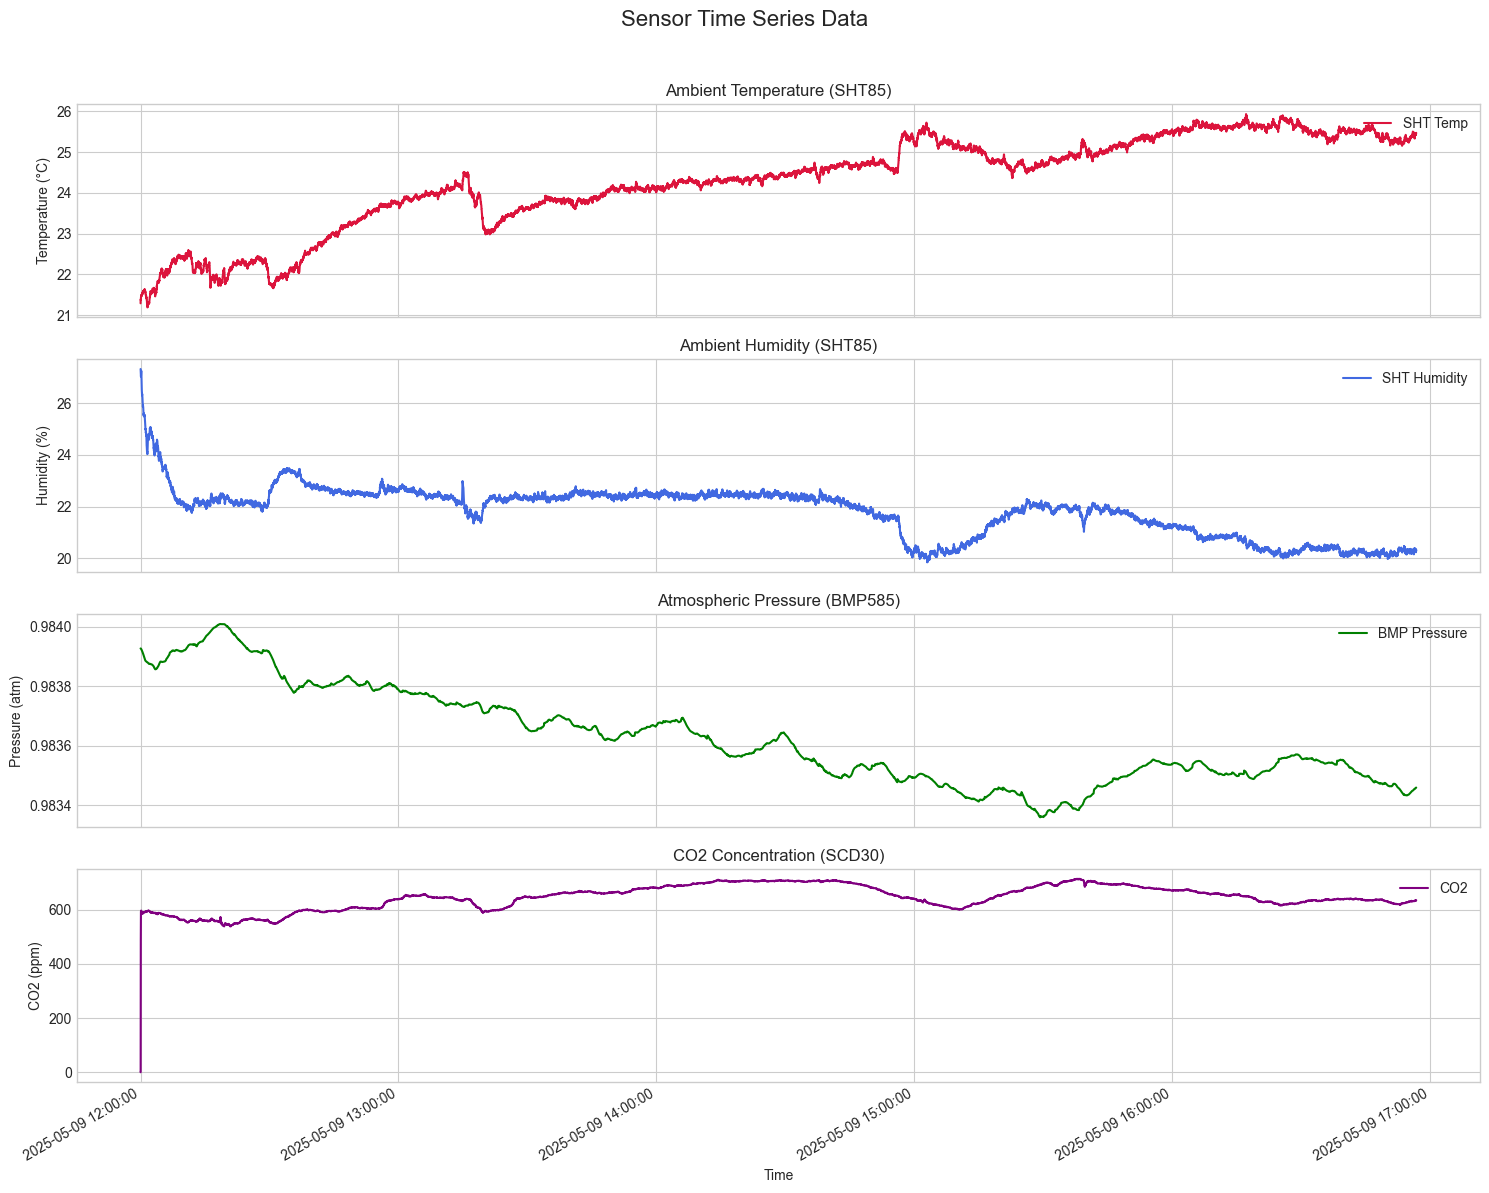

In [5]:
# --- 1) Time Series Subplots ---
print("Generating Plot 1: Time Series Data...")
fig1, axes1 = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
fig1.suptitle('Sensor Time Series Data', fontsize=16, y=0.99)

axes1[0].plot(df_plotting['Plot_Time'], df_plotting['SHT_TempC'], label='SHT Temp', color='crimson')
axes1[0].set_ylabel('Temperature (°C)')
axes1[0].legend(loc='upper right')
axes1[0].set_title('Ambient Temperature (SHT85)')

axes1[1].plot(df_plotting['Plot_Time'], df_plotting['SHT_Hum_%'], label='SHT Humidity', color='royalblue')
axes1[1].set_ylabel('Humidity (%)')
axes1[1].legend(loc='upper right')
axes1[1].set_title('Ambient Humidity (SHT85)')

axes1[2].plot(df_plotting['Plot_Time'], df_plotting['BMP_PressAtm'], label='BMP Pressure', color='green')
axes1[2].set_ylabel('Pressure (atm)')
axes1[2].legend(loc='upper right')
axes1[2].set_title('Atmospheric Pressure (BMP585)')

axes1[3].plot(df_plotting['Plot_Time'], df_plotting['CO2_ppm'], label='CO2', color='purple')
axes1[3].set_ylabel('CO2 (ppm)')
axes1[3].set_xlabel('Time')
axes1[3].legend(loc='upper right')
axes1[3].set_title('CO2 Concentration (SCD30)')

if pd.api.types.is_datetime64_any_dtype(df_plotting['Plot_Time']):
    fig1.autofmt_xdate() 
    axes1[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

plt.tight_layout(rect=[0, 0, 1, 0.97])
plot1_path = os.path.join(output_folder, "plot1_time_series.png")
plt.savefig(plot1_path)
print(f"Saved: {plot1_path}")
plt.show() # MODIFIED: Show plot
# plt.close(fig1) # MODIFIED: Commented out to show plot in Jupyter



Preprocessing data: removing outliers and preparing for aggregation...
Identified and marked 89 outliers as NaN in 'SHT_TempC'.
Identified and marked 183 outliers as NaN in 'SHT_Hum_%'.
Identified and marked 0 outliers as NaN in 'BMP_PressAtm'.
Identified and marked 4 outliers as NaN in 'CO2_ppm'.
Generating Plot 1: Time Series Data (1-min average with std bands)...
Saved: Data_Out\plot1_time_series_aggregated.png


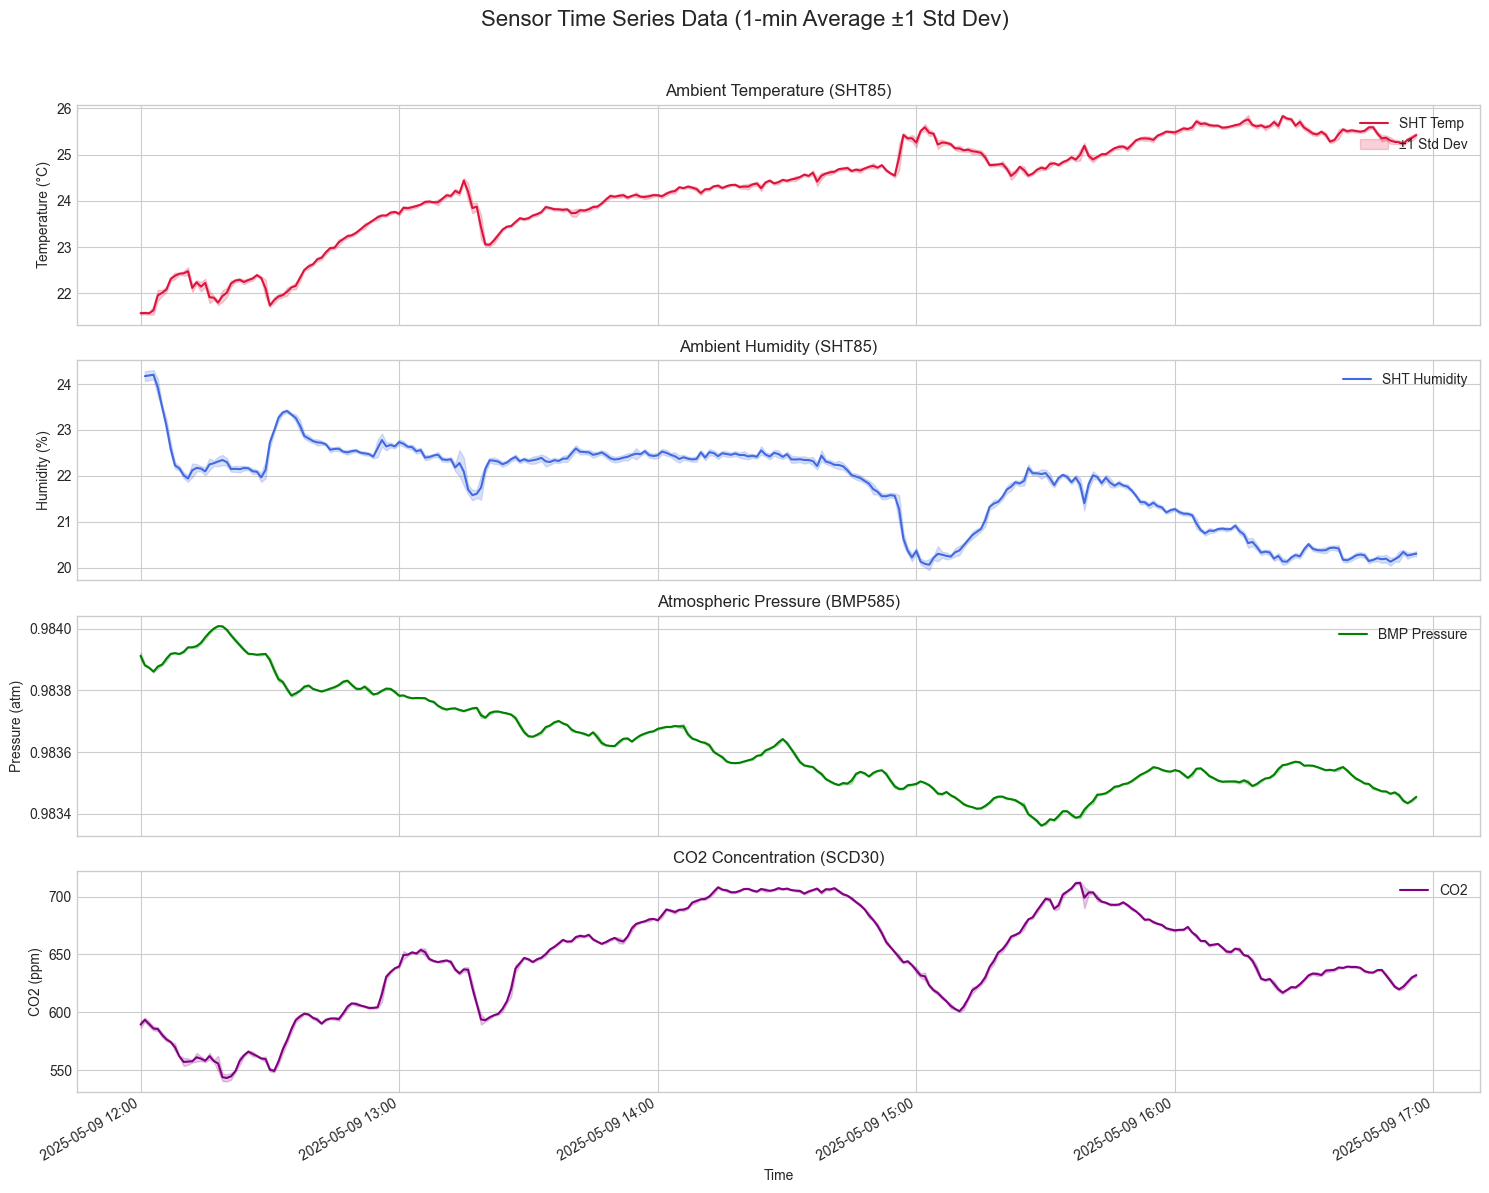

In [9]:
# --- Data Preprocessing ---
print("Preprocessing data: removing outliers and preparing for aggregation...")
df_processed = df_plotting.copy()

# Ensure Plot_Time is datetime and set as index
if not pd.api.types.is_datetime64_any_dtype(df_processed['Plot_Time']):
    df_processed['Plot_Time'] = pd.to_datetime(df_processed['Plot_Time'])
df_processed = df_processed.set_index('Plot_Time')

# Columns to process (same as your plotting columns)
sensor_columns = ['SHT_TempC', 'SHT_Hum_%', 'BMP_PressAtm', 'CO2_ppm']

# 1. Outlier Removal (using IQR method per column)
for col in sensor_columns:
    if col in df_processed.columns:
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Replace outliers with NaN. NaNs will be ignored by mean/std in resampling.
        df_processed[col] = df_processed[col].mask(
            (df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)
        )
        outliers_found = ((df_plotting[col] < lower_bound) | (df_plotting[col] > upper_bound)).sum()
        print(f"Identified and marked {outliers_found} outliers as NaN in '{col}'.")

# 2. Averaging for 1 minute and calculating standard deviation
# The '1T' or '1min' string means 1-minute frequency for resampling.
# .agg will compute both mean and std. NaN values are skipped by default.
df_aggregated = df_processed[sensor_columns].resample('1min').agg(['mean', 'std'])

# df_aggregated will now have multi-level columns, e.g., ('SHT_TempC', 'mean') and ('SHT_TempC', 'std')

# --- 1) Time Series Subplots (Modified) ---
print("Generating Plot 1: Time Series Data (1-min average with std bands)...")
fig1, axes1 = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
fig1.suptitle('Sensor Time Series Data (1-min Average ±1 Std Dev)', fontsize=16, y=0.99)

plot_configs = [
    {'col': 'SHT_TempC', 'label': 'SHT Temp', 'color': 'crimson', 'ylabel': 'Temperature (°C)', 'title': 'Ambient Temperature (SHT85)'},
    {'col': 'SHT_Hum_%', 'label': 'SHT Humidity', 'color': 'royalblue', 'ylabel': 'Humidity (%)', 'title': 'Ambient Humidity (SHT85)'},
    {'col': 'BMP_PressAtm', 'label': 'BMP Pressure', 'color': 'green', 'ylabel': 'Pressure (atm)', 'title': 'Atmospheric Pressure (BMP585)'},
    {'col': 'CO2_ppm', 'label': 'CO2', 'color': 'purple', 'ylabel': 'CO2 (ppm)', 'title': 'CO2 Concentration (SCD30)'}
]

for i, config in enumerate(plot_configs):
    ax = axes1[i]
    col_name = config['col']

    if (col_name, 'mean') not in df_aggregated.columns or (col_name, 'std') not in df_aggregated.columns:
        print(f"Warning: Mean or std for {col_name} not found in aggregated data. Skipping plot.")
        ax.set_title(f"{config['title']} (No data)")
        ax.set_ylabel(config['ylabel'])
        if i == len(plot_configs) -1 : ax.set_xlabel('Time')
        continue

    # Extract mean and std series
    mean_series = df_aggregated[(col_name, 'mean')].dropna() # Drop rows where mean is NaN (e.g., no data in interval)
    std_series = df_aggregated[(col_name, 'std')].reindex(mean_series.index).fillna(0) # Align and fill NaN std with 0

    if mean_series.empty:
        print(f"Warning: No data to plot for {col_name} after aggregation and NaN removal.")
        ax.set_title(f"{config['title']} (No data after aggregation)")
        ax.set_ylabel(config['ylabel'])
        if i == len(plot_configs) -1 : ax.set_xlabel('Time')
        continue

    # Plot the mean
    ax.plot(mean_series.index, mean_series, label=config['label'], color=config['color'])

    # Plot the standard deviation bands
    ax.fill_between(mean_series.index,
                    mean_series - std_series,
                    mean_series + std_series,
                    color=config['color'],
                    alpha=0.2, # Semi-transparent
                    label='±1 Std Dev' if i == 0 else None) # Add legend for std dev only once or customize

    ax.set_ylabel(config['ylabel'])
    ax.legend(loc='upper right')
    ax.set_title(config['title'])

axes1[3].set_xlabel('Time')

# Apply date formatting to the x-axis
if not df_aggregated.empty and pd.api.types.is_datetime64_any_dtype(df_aggregated.index):
    fig1.autofmt_xdate()
    axes1[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) # Adjusted format for clarity

plt.tight_layout(rect=[0, 0, 1, 0.97])
plot1_path = os.path.join(output_folder, "plot1_time_series_aggregated.png")
plt.savefig(plot1_path)
print(f"Saved: {plot1_path}")
plt.show()
# plt.close(fig1) # Keep commented if you want to see it in interactive environments

Generating Plot 2: Sensor Comparisons...
Saved: Data_Out\plot2_sensor_comparisons.png


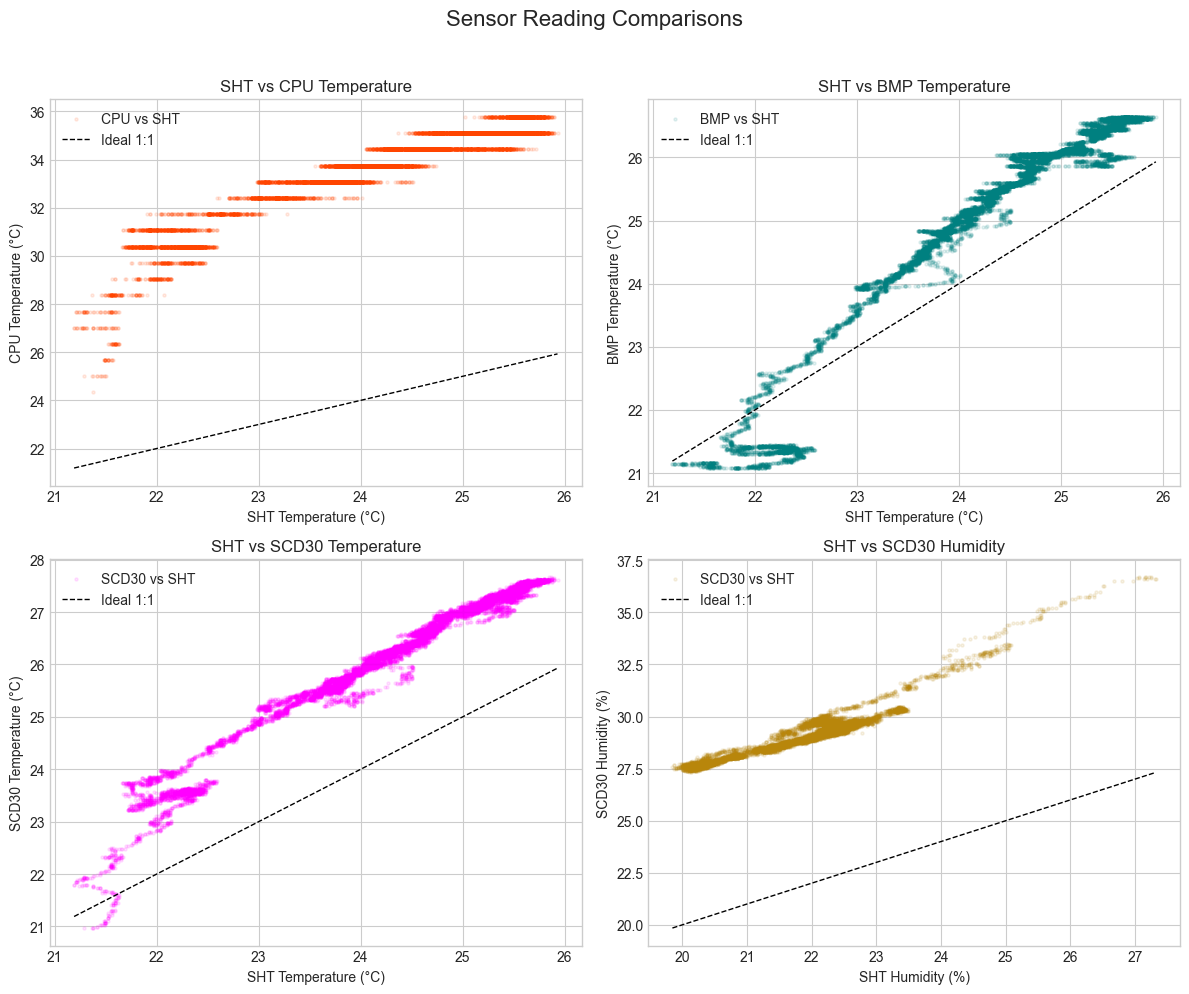

In [7]:
# --- 2) Sensor Comparison Subplots ---
print("Generating Plot 2: Sensor Comparisons...")
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))
fig2.suptitle('Sensor Reading Comparisons', fontsize=16, y=0.99)

scatter_alpha = 0.1 # This variable controls transparency
scatter_size = 5

axes2[0, 0].scatter(df_plotting['SHT_TempC'], df_plotting['CPU_TempC'], 
                    alpha=scatter_alpha, s=scatter_size, label='CPU vs SHT', color='orangered')
axes2[0, 0].set_xlabel('SHT Temperature (°C)')
axes2[0, 0].set_ylabel('CPU Temperature (°C)')
axes2[0, 0].set_title('SHT vs CPU Temperature')
axes2[0, 0].plot([df_plotting['SHT_TempC'].min(), df_plotting['SHT_TempC'].max()], 
                 [df_plotting['SHT_TempC'].min(), df_plotting['SHT_TempC'].max()], 
                 'k--', lw=1, label='Ideal 1:1') 
axes2[0, 0].legend()

axes2[0, 1].scatter(df_plotting['SHT_TempC'], df_plotting['BMP_TempC'], 
                    alpha=scatter_alpha, s=scatter_size, label='BMP vs SHT', color='teal')
axes2[0, 1].set_xlabel('SHT Temperature (°C)')
axes2[0, 1].set_ylabel('BMP Temperature (°C)')
axes2[0, 1].set_title('SHT vs BMP Temperature')
axes2[0, 1].plot([df_plotting['SHT_TempC'].min(), df_plotting['SHT_TempC'].max()], 
                 [df_plotting['SHT_TempC'].min(), df_plotting['SHT_TempC'].max()], 
                 'k--', lw=1, label='Ideal 1:1')
axes2[0, 1].legend()

axes2[1, 0].scatter(df_plotting['SHT_TempC'], df_plotting['SCD30_TempC'], 
                    alpha=scatter_alpha, s=scatter_size, label='SCD30 vs SHT', color='magenta')
axes2[1, 0].set_xlabel('SHT Temperature (°C)')
axes2[1, 0].set_ylabel('SCD30 Temperature (°C)')
axes2[1, 0].set_title('SHT vs SCD30 Temperature')
axes2[1, 0].plot([df_plotting['SHT_TempC'].min(), df_plotting['SHT_TempC'].max()], 
                 [df_plotting['SHT_TempC'].min(), df_plotting['SHT_TempC'].max()], 
                 'k--', lw=1, label='Ideal 1:1')
axes2[1, 0].legend()

axes2[1, 1].scatter(df_plotting['SHT_Hum_%'], df_plotting['SCD30_Hum_%'], 
                    alpha=scatter_alpha, s=scatter_size, label='SCD30 vs SHT', color='darkgoldenrod')
axes2[1, 1].set_xlabel('SHT Humidity (%)')
axes2[1, 1].set_ylabel('SCD30 Humidity (%)')
axes2[1, 1].set_title('SHT vs SCD30 Humidity')
axes2[1, 1].plot([df_plotting['SHT_Hum_%'].min(), df_plotting['SHT_Hum_%'].max()], 
                 [df_plotting['SHT_Hum_%'].min(), df_plotting['SHT_Hum_%'].max()], 
                 'k--', lw=1, label='Ideal 1:1')
axes2[1, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plot2_path = os.path.join(output_folder, "plot2_sensor_comparisons.png")
plt.savefig(plot2_path)
print(f"Saved: {plot2_path}")
plt.show() # MODIFIED: Show plot
# plt.close(fig2) # MODIFIED: Commented out

In [8]:
# --- 3) 3D Coordinates Plot ---
print("Generating Plot 3: 3D GPS Coordinates...")
gps_fixed_data = df_plotting[df_plotting['GPS_Fix'] == 1].copy()

coord_cols = ['GPS_Lon', 'GPS_Lat', 'GPS_Alt_m']
for col in coord_cols:
    gps_fixed_data[col] = pd.to_numeric(gps_fixed_data[col], errors='coerce')

gps_fixed_data.dropna(subset=coord_cols, inplace=True)

gps_fixed_data = gps_fixed_data[~((gps_fixed_data['GPS_Lon'] == 0) & \
                                  (gps_fixed_data['GPS_Lat'] == 0) & \
                                  (gps_fixed_data['GPS_Alt_m'] == 0))]

if not gps_fixed_data.empty and len(gps_fixed_data) > 1:
    fig3 = plt.figure(figsize=(10, 8))
    ax3d = fig3.add_subplot(111, projection='3d')
    
    ax3d.plot(gps_fixed_data['GPS_Lon'], 
              gps_fixed_data['GPS_Lat'], 
              gps_fixed_data['GPS_Alt_m'], 
              label='GPS Track', marker='o', markersize=2, linestyle='-')
    
    ax3d.scatter(gps_fixed_data['GPS_Lon'].iloc[0], gps_fixed_data['GPS_Lat'].iloc[0], gps_fixed_data['GPS_Alt_m'].iloc[0],
                 color='green', s=50, label='Start', depthshade=True)
    ax3d.scatter(gps_fixed_data['GPS_Lon'].iloc[-1], gps_fixed_data['GPS_Lat'].iloc[-1], gps_fixed_data['GPS_Alt_m'].iloc[-1],
                 color='red', s=50, label='End', depthshade=True)

    ax3d.set_xlabel('Longitude (°)')
    ax3d.set_ylabel('Latitude (°)')
    ax3d.set_zlabel('Altitude (m)')
    ax3d.set_title('3D GPS Track (where Fix=1)', fontsize=16)
    ax3d.legend()
    
    x_range = gps_fixed_data['GPS_Lon'].max() - gps_fixed_data['GPS_Lon'].min()
    y_range = gps_fixed_data['GPS_Lat'].max() - gps_fixed_data['GPS_Lat'].min()
    z_range = gps_fixed_data['GPS_Alt_m'].max() - gps_fixed_data['GPS_Alt_m'].min()
    max_range = max(x_range, y_range, z_range if z_range > 0 else (x_range+y_range)/2 if (x_range+y_range)>0 else 1 ) 
    if max_range == 0: max_range = 1 

    mid_x = (gps_fixed_data['GPS_Lon'].max() + gps_fixed_data['GPS_Lon'].min()) * 0.5
    mid_y = (gps_fixed_data['GPS_Lat'].max() + gps_fixed_data['GPS_Lat'].min()) * 0.5
    mid_z = (gps_fixed_data['GPS_Alt_m'].max() + gps_fixed_data['GPS_Alt_m'].min()) * 0.5
    
    if x_range > 0 : ax3d.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
    if y_range > 0 : ax3d.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
    if z_range > 0 : ax3d.set_zlim(mid_z - max_range * 0.5, mid_z + max_range * 0.5)
    elif 'GPS_Alt_m' in gps_fixed_data and not gps_fixed_data['GPS_Alt_m'].empty:
        alt_min = gps_fixed_data['GPS_Alt_m'].min()
        alt_max = gps_fixed_data['GPS_Alt_m'].max()
        if alt_min == alt_max:
             ax3d.set_zlim(alt_min - 1, alt_max + 1) # Provide a small range if all altitudes are same
        else: # Should be covered by z_range > 0 but as a fallback
             ax3d.set_zlim(alt_min, alt_max)


    plt.tight_layout()
    plot3_path = os.path.join(output_folder, "plot3_3d_coordinates.png")
    plt.savefig(plot3_path)
    print(f"Saved: {plot3_path}")
    plt.show() # MODIFIED: Show plot
    # plt.close(fig3) # MODIFIED: Commented out
elif gps_fixed_data.empty:
    print("No data with GPS_Fix=1 and valid coordinates found. Skipping 3D coordinate plot.")
else: # Only one point with GPS fix
    print("Only one data point with GPS_Fix=1 and valid coordinates found. Skipping 3D line plot, plotting single point.")
    fig3 = plt.figure(figsize=(10, 8))
    ax3d = fig3.add_subplot(111, projection='3d')
    ax3d.scatter(gps_fixed_data['GPS_Lon'].iloc[0], gps_fixed_data['GPS_Lat'].iloc[0], gps_fixed_data['GPS_Alt_m'].iloc[0],
                 color='blue', s=50, label='Single GPS Point', depthshade=True)
    ax3d.set_xlabel('Longitude (°)')
    ax3d.set_ylabel('Latitude (°)')
    ax3d.set_zlabel('Altitude (m)')
    ax3d.set_title('3D GPS Point (where Fix=1)', fontsize=16)
    ax3d.legend()
    plt.tight_layout()
    plot3_path = os.path.join(output_folder, "plot3_3d_coordinates.png")
    plt.savefig(plot3_path)
    print(f"Saved: {plot3_path}")
    plt.show() # MODIFIED: Show plot
    # plt.close(fig3) # MODIFIED: Commented out

print("\nFinished generating and saving plots.")

Generating Plot 3: 3D GPS Coordinates...
No data with GPS_Fix=1 and valid coordinates found. Skipping 3D coordinate plot.

Finished generating and saving plots.
